In [1]:
# Imports for plotting, data manipulation, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [2]:
# Dataframe imports and droppin unnecessary columns
file = 'data/cleaned_batting_df.csv'
file2 = 'data/cleaned_piching_df.csv'
file3 = 'data/cleaned_game_df.csv'
batting_df = pd.read_csv(file)
pitching_df = pd.read_csv(file2)
game_df = pd.read_csv(file3)
batting_df.drop('Unnamed: 0', axis=1, inplace=True)
pitching_df.drop('Unnamed: 0', axis=1, inplace=True)
game_df.drop('Unnamed: 0', axis=1, inplace=True)

## Batting Feature engineering ideas
- All of these stats will be on a PER PLATE APPEARANCE then divide by 162 to get PER GAME STATS
    - Team stats will be summed up and averaged - Will ultimately be compared to a teams 7 day trends history
        - 'totalBases' / total 'plateAppearances' - DONE
        - 'leftonbase'/ total 'plateAppearances' - DONE
        - 'runs' / total 'plateAppearances' - DONE
        - 'strikeOuts' / total 'atBats' - DONE
        - 'baseOnBalls' + 'intentionalWalks' / total 'plateAppearances' - DONE
            - 'hits' / total 'atBats' --- Leverage for game_df. get team stats per game...
            - 'obp' / # of batters on team --- Same as above
        - 'rbi' / total 'atBats' - DONE

In [3]:
# MIA & FLO team names are different. Standardizing to MIA
batting_df.replace(to_replace='FLA', value='MIA', inplace=True)

### Create New Features for TEAM season stats

In [4]:
# THIS IS THE FRAMEWORK TO GENERATE TEAM SEASON STATISTICS...
# Creating a dataframe containing each teams annual Batting Averages

a = batting_df.groupby(['year', 'teamAbbrev'])['hits'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['atBats'].sum()
a = a.to_frame()
b = b.to_frame()
BA = a.join(b, on=['year', 'teamAbbrev'])
BA['team_BA'] = round((BA['hits']/BA['atBats']), 3)
# BA = BA.reset_index()

In [5]:
# Total bases per plate appearance

a = batting_df.groupby(['year', 'teamAbbrev'])['totalBases'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
TB = a.join(b, on=['year', 'teamAbbrev'])
TB['total_bases_avg'] = round((TB['totalBases']/TB['plateAppearances']), 3)
# TB = TB.reset_index()

In [6]:
# LOB per plate appearnace

a = batting_df.groupby(['year', 'teamAbbrev'])['leftOnBase'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
LOB = a.join(b, on=['year', 'teamAbbrev'])
LOB['LOB_avg'] = round((LOB['leftOnBase']/LOB['plateAppearances']), 3)
# LOB = LOB.reset_index()

In [7]:
# Runs per plate appearance

a = batting_df.groupby(['year', 'teamAbbrev'])['runs'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
RUNS = a.join(b, on=['year', 'teamAbbrev'])
RUNS['runs_avg'] = round((RUNS['runs']/RUNS['plateAppearances']), 3)
# RUNS = RUNS.reset_index()

In [8]:
# K's per AtBat

a = batting_df.groupby(['year', 'teamAbbrev'])['strikeOuts'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['atBats'].sum()
a = a.to_frame()
b = b.to_frame()
K = a.join(b, on=['year', 'teamAbbrev'])
K['K_avg'] = round((K['strikeOuts']/K['atBats']), 3)
# K = K.reset_index()

In [9]:
# BB per plate appearance

a = batting_df.groupby(['year', 'teamAbbrev'])['baseOnBalls'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
BB = a.join(b, on=['year', 'teamAbbrev'])
BB['BB_avg'] = round((BB['baseOnBalls']/BB['plateAppearances']), 3)
# BB = BB.reset_index()

In [10]:
# RBI per plate appearance

a = batting_df.groupby(['year', 'teamAbbrev'])['rbi'].sum()
b = batting_df.groupby(['year', 'teamAbbrev'])['plateAppearances'].sum()
a = a.to_frame()
b = b.to_frame()
RBI = a.join(b, on=['year', 'teamAbbrev'])
RBI['RBI_avg'] = round((RBI['rbi']/RBI['plateAppearances']), 3)
# RBI = RBI.reset_index()

## Merge all the TEAM stats into one dataframe

In [11]:
team_stats_lst = [BA, TB, LOB, RUNS, K, BB, RBI]

In [12]:
team_stats = pd.concat(team_stats_lst, join='outer', axis=1)

In [13]:
# Reset the index so years can be accessible
team_stats = team_stats.reset_index()

In [14]:
# Confirming that 'year' is now accessible
team_stats.columns
# It is!

Index(['year', 'teamAbbrev', 'hits', 'atBats', 'team_BA', 'totalBases',
       'plateAppearances', 'total_bases_avg', 'leftOnBase', 'plateAppearances',
       'LOB_avg', 'runs', 'plateAppearances', 'runs_avg', 'strikeOuts',
       'atBats', 'K_avg', 'baseOnBalls', 'plateAppearances', 'BB_avg', 'rbi',
       'plateAppearances', 'RBI_avg'],
      dtype='object')

## Pitching Feature ideas
- Pitching stats will focus on starting pitchers Per9 innings stat (except for certain features)
    - 'winningPercentage'
    - 'runsScoredPer9'
    - 'hitsPer9'
    - 'era'
    - 'whip'

In [15]:
# Rearrange the pitching_df so the columns have a better flow
pitching_df = pitching_df.reindex(columns=['year','playerName','teamAbbrev','winningPercentage','runsScoredPer9','hitsPer9','strikeoutsPer9','baseOnBallsPer9','homeRunsPer9','era','whip','ops','gidp','avg'])
# Columns to be left out from the reindexing --- 'winPercentage', 'strikeoutsPer9Inn', 'walksPer9Inn', 'hitsPer9Inn'

In [16]:
# Marlins have the team labels: MIA & FLO. Standardizing to MIA
pitching_df.replace(to_replace='FLA', value='MIA', inplace=True)

## Game DF Feature ideas
- Turn VisitorRunsScored & HomeRunsScore into a column that indicates if the home team won - DONE.
- Combine VisitorHBP & VisitorBB & VisitorIBB into a single column containing all the stats - DONE.
- Same with HomeHBP & HomeBB & HomeIBB - DONE.
<br/><br/>
- Combine VisitorH / VisitorAB = team_BA - DONE.
- Same with HomeH / HomeAB - DONE. 
<br/><br/>
- Eventually add on all the other engineered features into this dataframe...
<br/><br/>
- Since the game_df has a date column, I'd like to leverage that to look at 7-day-trends, 14-day-trends, etc

In [17]:
# Creating a Target column for the model to eventually train on
game_df['Home_team_won?'] = game_df['HomeRunsScore'] > game_df['VisitorRunsScored']

In [18]:
# Adding a Home & Away BA per game to compare batting trends over time
game_df['Visitor_BA'] = round((game_df['VisitorH'] / game_df['VisitorAB']), 3)
game_df['Home_BA'] = round((game_df['HomeH'] / game_df['HomeAB']), 3)

In [19]:
# Creating a new column in order to add Date/Time to my dataframe
game_df['New_Date'] = pd.to_datetime(game_df['Date'].astype(str), format='%Y%m%d')

In [20]:
# Rearranging columns so new date/time is at the front of the DF & dropping old date column since it was an integer
game_df = game_df.reindex(columns=['New_Date','Date', 'VisitingTeam','VisitorStartingPitcherName','HomeTeam','HomeStartingPitcherName', 'VisitorRunsScored','HomeRunsScore', 'VisitorAB', 'VisitorH','Visitor_BA', 'VisitorHBP', 'VisitorBB','VisitorIBB', 'VisitorLOB', 'HomeAB', 'HomeH', 'Home_BA', 'HomeHBP', 'HomeBB', 'HomeIBB', 'HomeLOB', 'Home_team_won?'])
game_df.drop('Date', axis='columns', inplace=True)

In [21]:
# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA
game_df.replace(to_replace='FLO', value='MIA', inplace=True)

# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
game_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)

In [22]:
# Adding a prior year column in order to match last seasons stats from pitching_df/team_stats to game_df
game_df['prior_year'] = game_df['New_Date'].dt.year-1

## Merge pitching_df stats to game_df

In [23]:
# Merging the pitching stats on the prior year in the game_df in order to leverage the pitchers
# Doing it twice for home & away starting pitchers
game_df = game_df.merge(pitching_df, how='left', left_on=['prior_year','VisitorStartingPitcherName'], right_on=['year', 'playerName'])
game_df = game_df.merge(pitching_df, how='left', left_on=['prior_year','HomeStartingPitcherName'], right_on=['year', 'playerName'])

## Merge Team Batting stats to game_df

In [24]:
# Dropping redundant columns from batting stats df
team_stats.drop('plateAppearances', axis=1, inplace=True)

In [25]:
# Merging away team stats
game_df = game_df.merge(team_stats, how='left', left_on=['prior_year', 'VisitingTeam'], right_on=['year', 'teamAbbrev'])
# Merging home team stats
game_df = game_df.merge(team_stats, how='left', left_on=['prior_year', 'HomeTeam'], right_on=['year', 'teamAbbrev'])
# Creating an integer reference point in game_df
game_df['current_year'] = game_df['New_Date'].dt.year

C:\Users\Sreeman\AppData\Local\Temp\ipykernel_14640\1329650456.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'teamAbbrev_x', 'year_x'} in the result is deprecated and will raise a MergeError in a future version.
  game_df = game_df.merge(team_stats, how='left', left_on=['prior_year', 'HomeTeam'], right_on=['year', 'teamAbbrev'])


In [26]:
# Addressing NaN values in game_df by giving them a -1 score
# NaN indicates that the player did not have stats from the prior year to measure against
game_df.fillna(value = -1, inplace=True)

In [27]:
# Checking game_df for ANY NaN values
game_df.isnull().values.any()
# Returns false, indicating that there are NO NaN values in the game_df

False

In [28]:
def my_train_test_split(X, y, start_year, end_year):
    '''
    creating a custom train_test_split in order to split data by seasons
    i.e.
    - train on 2010-2016 seasons
    - test on 2018-2019 seasons
    
    Parameters:
    X: features
    y: target value
    
    returns:
    X_train, X_test, y_train, y_test
    '''

    # Getting X values to_numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    X.fillna(value = -1, inplace=True)
    
    # Setting up how to break up seasons by years
    years = np.arange(start_year, end_year+1)
    mask = game_df['current_year'].isin(years)
    
    # Splitting between the training & testing sets
    X_train = X[mask]
    X_test = X[~mask]
    y_train = y[mask]
    y_test = y[~mask]

    return X_train, X_test, y_train, y_test

In [29]:
def plot_features_importance(model, color, X_train):
    '''
    A function to plot feature importances
    
    parameter:
    model - the variable that we fit our model to. i.e. RF = RandomForest()
    color - a string that will assign the graphs color scheme
    
    returns:
    a plot highlighting feature importance
    '''
    model.feature_importances_
    importances = pd.Series(data=model.feature_importances_, index= X_train.columns)
    importances_sorted = importances.sort_values()
    importances_sorted.plot(kind='barh', color=color, figsize=(15,10))

### Post merge:
#### _x values are associated with the visiting team
#### _y values are associated with the home team

# XGBoost Analysis

#### First model being trained will be on the teams/starting pitcher prior year statistics

In [30]:
# Creating an initial drop_lst variable to use for dropping metrics that are current game metrics
drop_lst2 = ['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y',
'year_x',
'year_y',
'prior_year']

In [31]:
y = game_df['Home_team_won?']
X = game_df.drop(drop_lst2, axis=1)

In [32]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2018)
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [33]:
# Instantiate, fit, and predict with XGBClassifier
gb = XGBClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [34]:
# True indicates that the Home TEAM WON 
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
False,536,607
True,461,825


In [35]:
print(f"Accuracy of historic stats: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy of historic stats: 56.03%


In [36]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(gb, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 52.49%


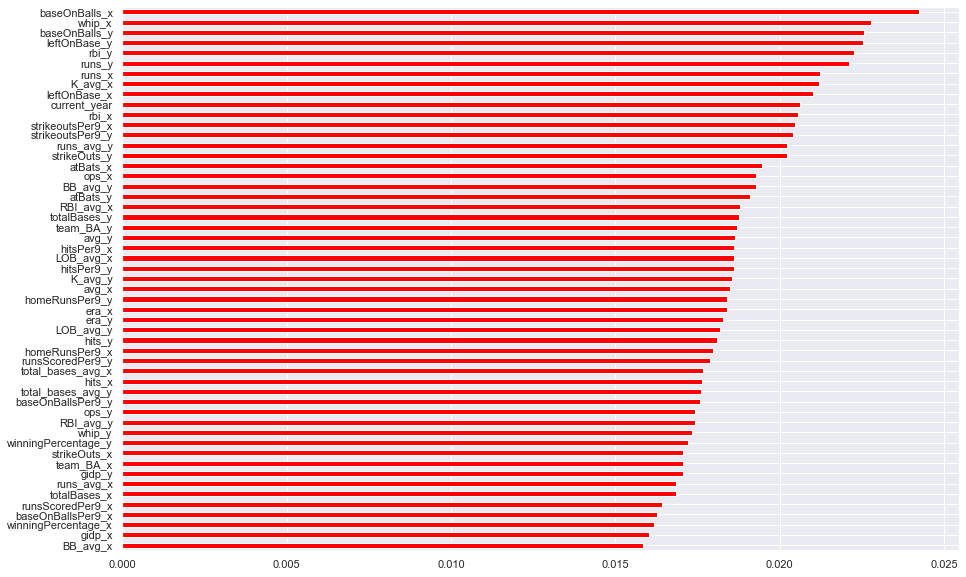

In [37]:
# Generating feature importance from prior year team offensive stats as well as starting pitchers stats
plot_features_importance(gb, "red", X_train)

## Adding a rolling 3-day & 7-day average for teams:
- Batting averages ( sum(Hits) / sum(AtBats) )
- Run averages ( sum(runs) / 7-games )
- OBP averages ( sum(Hits + BB + IBB + HBP) / sum(AtBats + BB + IBB + HBP) ) # denom is sum of plate appearances

## Create Home & Away OBP stats

In [38]:
game_df['Visitor_OBP'] = round((game_df['VisitorH'] + game_df['VisitorHBP'] + game_df['VisitorIBB'] + game_df['VisitorBB']) / (game_df['VisitorAB'] + game_df['VisitorHBP'] + game_df['VisitorIBB'] + game_df['VisitorBB']), 3)
game_df['Home_OBP'] = round((game_df['HomeH'] + game_df['HomeHBP'] + game_df['HomeIBB'] + game_df['HomeBB']) / (game_df['HomeAB'] + game_df['HomeHBP'] + game_df['HomeIBB'] + game_df['HomeBB']), 3)

## Create Home & Away 3d & 7d OBP trends

In [39]:
game_df['3d_homeOBP_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_OBP'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_homeOBP_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_OBP'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))
game_df['3d_visitorOBP_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_OBP'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_visitorOBP_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_OBP'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))

## Create Home & Away 3d & 7d scoring trends

In [40]:
game_df['3d_homescore_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['HomeRunsScore'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_homescore_avg'] = game_df.groupby(['current_year', 'HomeTeam'])['HomeRunsScore'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))
game_df['3d_visitorscore_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['VisitorRunsScored'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_visitorscore_avg'] = game_df.groupby(['current_year', 'VisitingTeam'])['VisitorRunsScored'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))

## Create Home & Away 3d & 7d Batting Average trends

In [41]:
game_df['3d_homeBA'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_BA'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_homeBA'] = game_df.groupby(['current_year', 'HomeTeam'])['Home_BA'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))
game_df['3d_visitorBA'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_BA'].transform(lambda x: round(x.rolling(3).mean().shift(periods=1, axis=0), 3))
game_df['7d_visitorBA'] = game_df.groupby(['current_year', 'VisitingTeam'])['Visitor_BA'].transform(lambda x: round(x.rolling(7).mean().shift(periods=1, axis=0), 3))

#### Seems like everything worked... now to train and test different models with the additional engineered features

In [42]:
# Created a 2nd drop_lst2 to take out additional columns that were created for previous modeling
drop_lst2 = ['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y',
'year_x',
'year_y',
'prior_year',
'Visitor_OBP',
'Home_OBP',
'winningPercentage_x', 'runsScoredPer9_x', 'hitsPer9_x',
'strikeoutsPer9_x', 'baseOnBallsPer9_x', 'homeRunsPer9_x', 'era_x',
'whip_x', 'ops_x', 'gidp_x', 'avg_x', 'winningPercentage_y',
'runsScoredPer9_y', 'hitsPer9_y', 'strikeoutsPer9_y',
'baseOnBallsPer9_y', 'homeRunsPer9_y', 'era_y', 'whip_y', 'ops_y',
'gidp_y', 'avg_y', 'hits_x', 'team_BA_x', 'totalBases_x',
'total_bases_avg_x', 'leftOnBase_x', 'LOB_avg_x', 'runs_x',
'runs_avg_x', 'strikeOuts_x', 'atBats_x', 'K_avg_x', 'baseOnBalls_x',
'BB_avg_x', 'rbi_x', 'RBI_avg_x', 'hits_y', 'team_BA_y', 'totalBases_y',
'total_bases_avg_y', 'leftOnBase_y', 'LOB_avg_y', 'runs_y',
'runs_avg_y', 'strikeOuts_y', 'atBats_y', 'K_avg_y', 'baseOnBalls_y',
'BB_avg_y', 'rbi_y', 'RBI_avg_y', ]

In [43]:
# Separate 3-day & 7-day trends into dropable lists
three_day_trends2 = ['3d_homeOBP_avg', '3d_visitorOBP_avg', '3d_homescore_avg', '3d_visitorscore_avg', '3d_homeBA', '3d_visitorBA']
seven_day_trends2 = ['7d_homeOBP_avg','7d_visitorOBP_avg','7d_homescore_avg','7d_visitorscore_avg','7d_homeBA','7d_visitorBA']

## Test on 3d trends first

In [44]:
y = game_df['Home_team_won?']
X = game_df.drop(drop_lst2, axis=1)
X = X.drop(seven_day_trends2, axis=1)

In [45]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2018)
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [46]:
gb2 = XGBClassifier()
gb2.fit(X_train, y_train)
y_pred = gb2.predict(X_test)

In [47]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
False,454,689
True,518,768


In [48]:
print(f"Accuracy for 3d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for 3d trends: 50.31%


In [49]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(gb2, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 51.15%


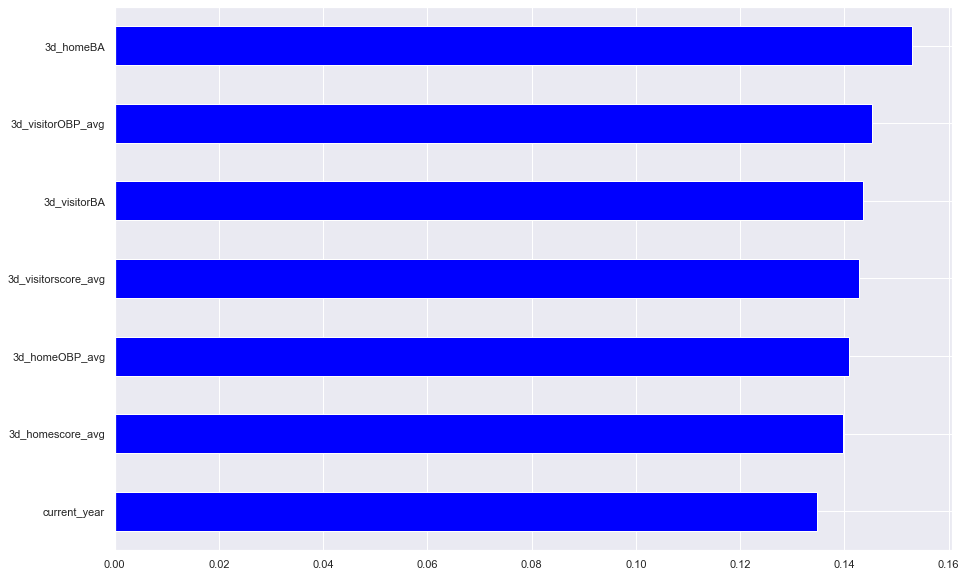

In [50]:
plot_features_importance(gb2, "blue", X_train)

## Now test 7d trends

In [51]:
y = game_df['Home_team_won?']
X = game_df.drop(drop_lst2, axis=1)
X = X.drop(three_day_trends2, axis=1)

In [52]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2018)
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [53]:
gb2_7 = XGBClassifier()
gb2_7.fit(X_train, y_train)
y_pred = gb2_7.predict(X_test)

In [54]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
False,380,763
True,403,883


In [55]:
print(f"Accuracy for 7d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for 7d trends: 52.0%


In [56]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(gb2_7, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 50.88%


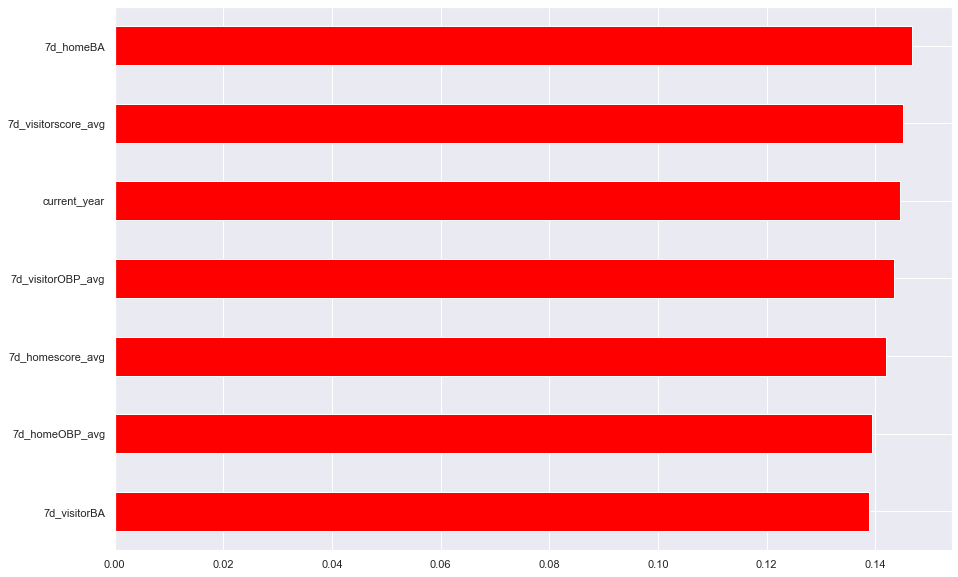

In [57]:
plot_features_importance(gb2_7, "red", X_train)

### Going to try and model with:
    - historic trends & 3d
    - historic trends & 7d
    - historic trends with 3d & 7d trends

### Will train a RandomForest model on historitc team stats, 3d, and 7d trends.

In [58]:
# More or less the same features being dropped from before but adding 2 new features added to the game_df
new_drop_lst2 = ['New_Date',
'VisitingTeam',
'VisitorStartingPitcherName',
'HomeTeam',
'HomeStartingPitcherName',
'VisitorRunsScored', 
'HomeRunsScore', 
'Home_team_won?', 
'VisitorAB',
'VisitorH',
'Visitor_BA',
'VisitorHBP',
'VisitorBB',
'VisitorIBB',
'VisitorLOB',
'HomeAB',
'HomeH',
'Home_BA',
'HomeHBP',
'HomeBB',
'HomeIBB',
'HomeLOB',
'playerName_x',
'teamAbbrev_x',
'playerName_y',
'teamAbbrev_y',
'teamAbbrev_x',
'teamAbbrev_y',
'year_x',
'year_y',
'prior_year',
'Visitor_OBP',
'Home_OBP']

### Will leverage 3d trends first...

In [59]:
y = game_df['Home_team_won?']
X = game_df.drop(new_drop_lst2, axis=1)
X = X.drop(seven_day_trends2, axis=1)

In [60]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2018)
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [61]:
gb = XGBClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [62]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
False,558,585
True,471,815


In [63]:
print(f"Accuracy for historic + 3d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for historic + 3d trends: 56.53%


In [64]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(gb, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 52.48%


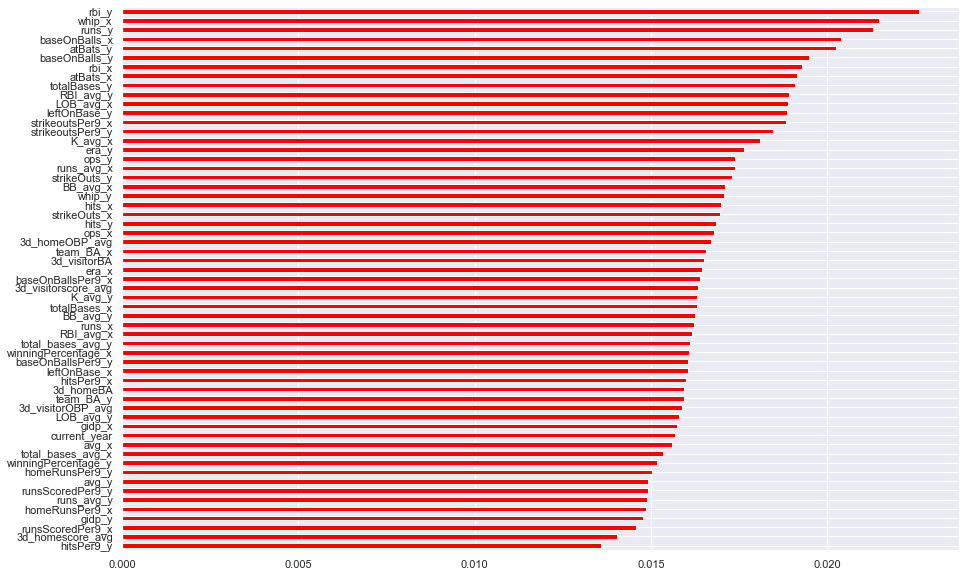

In [65]:
plot_features_importance(gb, "red", X_train)

### Now leverage 7d trends

In [66]:
y = game_df['Home_team_won?']
X = game_df.drop(new_drop_lst2, axis=1)
X = X.drop(three_day_trends2, axis=1)

In [67]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2018)
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [68]:
gb = XGBClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [69]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
False,567,576
True,494,792


In [70]:
print(f"Accuracy for historic + 7d trends: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy for historic + 7d trends: 55.95%


In [71]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(gb, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 52.38%


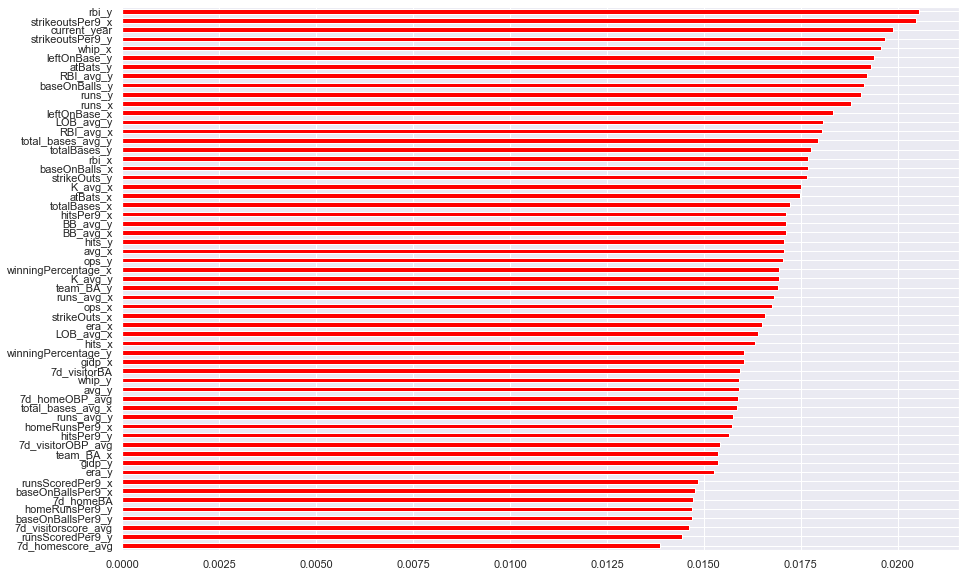

In [72]:
plot_features_importance(gb, "red", X_train)

## Now, model with historic, 3d, and 7d trends...

In [73]:
y = game_df['Home_team_won?']
X = game_df.drop(new_drop_lst2, axis=1)

In [74]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 2010, 2018)
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [75]:
# gb = XGBClassifier()
# gb.fit(X_train, y_train)
# y_pred = gb.predict(X_test)
gb = XGBClassifier()
# params_dict = {'learning_rate': [.0001, .001, .01],
#                'n_estimators': [200,300,400]}
# params_dict = {'learning_rate': [.01, 0.05],
#                'n_estimators': [100,200,300]}
# params_dict = {'learning_rate': [0.075,.01, 0.02],
#                'n_estimators': [250,300]}
# params_dict = {'learning_rate': [0.085,.01],
#                'n_estimators': [150,200]}
# params_dict = {'learning_rate': [0.080,.012],
#                'n_estimators': [180,220]} 59.12%
# params_dict = {'learning_rate': [.012,0.014],
#                'n_estimators': [180,200]}
params_dict = {'learning_rate': [0.080,.012],
                'n_estimators': [180,220]}
grid_gb = GridSearchCV(gb, param_grid=params_dict, scoring='accuracy', cv=5, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_param = grid_gb.best_params_
best_cv_score = grid_gb.best_score_
best_model = grid_gb.best_estimator_
test_acc = best_model.score(X_test, y_test)
print(f"GradientBoosted with GridSearchCV accuracy: {round((test_acc*100),2)}%")

GradientBoosted with GridSearchCV accuracy: 59.12%


In [76]:
print(best_param)
print(best_model)

{'learning_rate': 0.012, 'n_estimators': 180}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.012, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [77]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
False,567,576
True,494,792


In [79]:
print(f"Cross-validation score is: {round(np.mean(cross_val_score(grid_gb, X_train, y_train, cv=5))*100, 2)}%")

Cross-validation score is: 54.29%


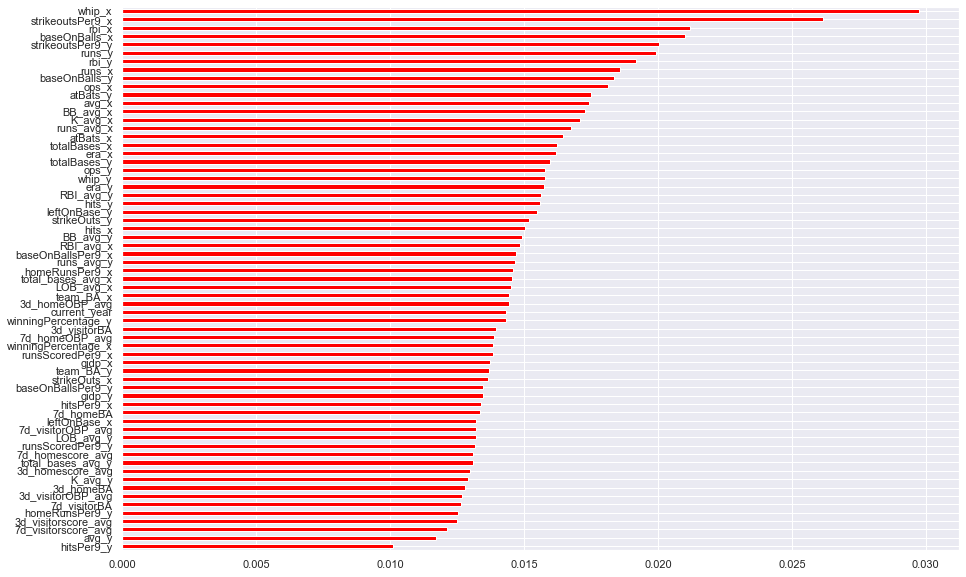

In [80]:
plot_features_importance(grid_gb.best_estimator_, "red", X_train)